In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install emoji
!pip install transformers

import pickle
from collections import Counter
import os
import tqdm
import pandas as pd
import numpy as np
from emoji import demojize
from nltk.tokenize import TweetTokenizer
from sklearn import metrics
import transformers
import torch
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from transformers import AutoTokenizer, AutoModel, AutoConfig
from sklearn.metrics import confusion_matrix
# from pretty_confusion_matrix import pp_matrix

import warnings
warnings.simplefilter('ignore')


# Setting up the device for GPU usage
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'

In [5]:
tokenizer_ = TweetTokenizer()

def normalizeToken_(token):
    lowercased_token = token.lower()
    if token.startswith("@"):
        return "@USER"
    elif lowercased_token.startswith("http") or lowercased_token.startswith("www"):
        return "HTTPURL"
    elif len(token) == 1:
        return demojize(token) # //TODO
    else:
        return token


def normalizeTweet(tweet):
    tokens = tokenizer_.tokenize((tweet).lower())
    normTweet = " ".join([normalizeToken_(token) for token in tokens])

    normTweet = (
        normTweet.replace("cannot ", "can not ")
        .replace("n't ", " n't ")
        .replace("n 't ", " n't ")
        .replace("ca n't", "can't")
        .replace("ai n't", "ain't")
    )
    normTweet = (
        normTweet.replace("'m ", " 'm ")
        .replace("'re ", " 're ")
        .replace("'s ", " 's ")
        .replace("'ll ", " 'll ")
        .replace("'d ", " 'd ")
        .replace("'ve ", " 've ")
    )
    normTweet = (
        normTweet.replace(" p . m .", "  p.m.")
        .replace(" p . m ", " p.m ")
        .replace(" a . m .", " a.m.")
        .replace(" a . m ", " a.m ")
    )

    return (" ".join(normTweet.split()))

class BERTweetclass(torch.nn.Module):
    def __init__(self):
        super(BERTweetclass, self).__init__()
        self.l1 = transformers.AutoModel.from_pretrained(model_path,
                                                         return_dict=False)
        self.l2 = torch.nn.Dropout(0.3)
        self.l3 = torch.nn.Linear(768, 2)

    def forward(self, ids, mask, token_type_ids):
        _, output_1= self.l1(ids, attention_mask = mask, token_type_ids = token_type_ids)
        output_2 = self.l2(output_1)
        output = self.l3(output_2)
        return output


def loss_fn(outputs, targets):
    return torch.nn.BCEWithLogitsLoss()(outputs, targets)


def train(epoch):
    model.train()
    for _,data in enumerate(training_loader, 0):
        ids = data['ids'].to(device, dtype = torch.long)
        mask = data['mask'].to(device, dtype = torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
        targets = data['targets'].to(device, dtype = torch.float)

        outputs = model(ids, mask, token_type_ids)

        optimizer.zero_grad()
        loss = loss_fn(outputs, targets)
        if _%5000==0:
            print(f'Epoch: {epoch}, Loss:  {loss.item()}')

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


def validation(validation_l):
    model.eval()
    fin_targets=[]
    fin_outputs=[]
    with torch.no_grad():
        for _, data in enumerate(validation_l, 0):
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            targets = data['targets'].to(device, dtype = torch.float)
            outputs = model(ids, mask, token_type_ids)
            fin_targets.extend(targets.cpu().detach().numpy().tolist())
            fin_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())
    return fin_outputs, fin_targets

class CustomDataset(Dataset):

    def __init__(self, dataframe, tokenizer_, max_len, label=None):
        self.tokenizer = tokenizer_
        self.data = dataframe
        self.tweet_normalize_ = dataframe.tweet_normalize
        self.targets = dataframe.label if label is None else label
        self.max_len = max_len

    def __len__(self):
        return len(self.tweet_normalize_)

    def __getitem__(self, index):
        #print(index)
        tweet_normalize = str(self.tweet_normalize_[index])
        #print(tweet_normalize)
        tweet_normalize = " ".join(tweet_normalize.split())
        inputs = self.tokenizer.encode_plus(
            tweet_normalize,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            pad_to_max_length=True,
            return_token_type_ids=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs["token_type_ids"]


        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'targets': torch.tensor(self.targets[index], dtype=torch.float)
        }

In [7]:
dataset

,concat_fields,title,selftext,unicode_text_concat,platform,signal
0,Double tap if you believe in Bitcoin!⚡🧡\n\nJus...,NaN,NaN,double tap if you believe in a_coin_name ! ⚡ 🧡...,instagram,not buy
1,Leash power by @ Oskitarfiera/ twitter\n\n👉🏽Fo...,NaN,NaN,leash power by @user oskitarfiera / twitter 👉🏽...,instagram,not buy
2,#ShibArmy #ShibaToTheMoon #IamRyoshi #IamShiba...,NaN,NaN,#shibarmy #shibatothemoon #iamryoshi #iamshiba...,instagram,not buy
3,"Your habits dictate your future, if you wanna ...",NaN,NaN,"your habits dictate your future , if you wanna...",instagram,buy
4,This is the next world of woman 100x NFT proje...,NaN,NaN,this is the next world of woman a_number x nft...,instagram,buy
...,...,...,...,...,...,...
5718,Simon Dixon and Mauricio Di Bartlolomeo - Swan...,NaN,NaN,simon dixon and mauricio di bartlolomeo - swan...,twitter,not buy
5719,🇺🇦 The Ukrainian government has raised over $4...,NaN,NaN,🇺 🇦 the ukrainian government has raised over $...,twitter,not buy
5720,JUST IN: The number of addresses holding at le...,NaN,NaN,just in : the number of addresses holding at l...,twitter,buy
5721,Conditions ‘ripe’ for Bitcoin adoption amid ge...,NaN,NaN,conditions ‘ ripe ’ for a_coin_name adoption a...,twitter,buy


In [8]:
path= 'drive/MyDrive/crypto-classifier/data/multy_platform'

with open (path+'/cleanTweet6000_signal.pickle', 'rb') as fp:
    dataset = pickle.load(fp)

data=dataset[dataset['platform']=='reddit'].reset_index(drop=True)



# X = data['unicode_text_concat'].to_list()
y = data['signal'].to_list()

labels = {'not buy':0, 'buy':1}
for i in range(len(y)):
  data['signal'][i]=labels[data['signal'][i]]

data = data[['concat_fields','platform','signal']].rename(columns={'concat_fields':'tweet', 'signal':'labl'})

data['tweet_normalize']=data['tweet'].apply(normalizeTweet)
ls=[]
for i in range(len(data)):
  if data['labl'][i]==1:
    ls.append([0,1])
  else:
    ls.append([1,0])

data['label']=(ls)
data

,tweet,platform,labl,tweet_normalize,label
0,"As sad as it is looking at a RED investment, y...",reddit,0,"as sad as it is looking at a red investment , ...","[1, 0]"
1,$17m market cap; VC backing; Proof of Value co...,reddit,1,$ 17m market cap ; vc backing ; proof of value...,"[0, 1]"
2,ADA is going to be the next boom?\n SELFTEXT: ...,reddit,1,ada is going to be the next boom ? selftext : ...,"[0, 1]"
3,"I've retired thanks to crypto, but there's som...",reddit,0,"i 've retired thanks to crypto , but there 's ...","[1, 0]"
4,We need to stop thinking ‘promoting women in c...,reddit,0,we need to stop thinking ‘ promoting women in ...,"[1, 0]"
...,...,...,...,...,...
1960,"MaskedDAO👺, Shared Revenue through NFT utility...",reddit,1,"maskeddao :goblin: , shared revenue through nf...","[0, 1]"
1961,Help me calculate this\n SELFTEXT: if i buy $1...,reddit,0,help me calculate this selftext : if i buy $ 1...,"[1, 0]"
1962,Coinbase stole my money\n SELFTEXT: Case #4604...,reddit,0,coinbase stole my money selftext : case #46047...,"[1, 0]"
1963,Cardano Memes? I haven't really seen many\n SE...,reddit,0,cardano memes ? i have n't really seen many se...,"[1, 0]"


In [ ]:
!pip install python-bidi
!pip install arabic_reshaper

from bidi.algorithm import get_display
import arabic_reshaper as ar

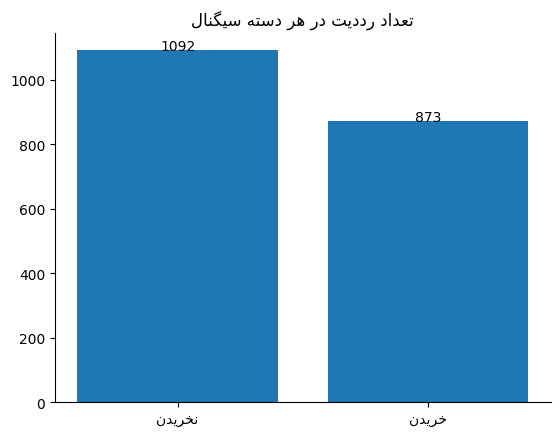

In [95]:
def plot_with_borders(x, y,plot_name,file_name):
    fig, ax = plt.subplots()
    ax.bar(x, y)

    # Set the left and bottom spines to be visible
    ax.spines['left'].set_visible(True)
    ax.spines['bottom'].set_visible(True)

    # Set the top and right spines to be invisible
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # Display the height of bars on the plot
    for i, v in enumerate(y):
        ax.text(i, v + 0.5, str(v), ha='center')

    # Set the title of the figure
    plt.title(disppersian(plot_name))

    # Save the plot with 1080 resolution
    plt.savefig(f'{file_name}.png', dpi=1080)



    plt.show()


dictionary_of_signal_bnb = {0:'نخریدن',
                        1:'خریدن'}


from collections import Counter
import matplotlib.pyplot as plt
disppersian = lambda text : get_display(ar.reshape(text))

x=list(Counter(data['labl'].apply(lambda x:disppersian(dictionary_of_signal_bnb[x]))).keys())
y=list(Counter(data['labl'].apply(lambda x:disppersian(dictionary_of_signal_bnb[x]))).values())
plot_with_borders(x, y,'تعداد رددیت در هر دسته سیگنال','signal2_reddit_count')




In [9]:
def test(validation_l):
    model.eval()
    fin_targets=[]
    fin_outputs=[]
    with torch.no_grad():
        for _, data in enumerate(validation_l, 0):
            # print(_)
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            outputs = model(ids, mask, token_type_ids)
            fin_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())
            fin_targets.extend(data['targets'])
    return fin_outputs, fin_targets

### Defining some key variables that will be used later on in the training


In [39]:
MAX_LEN = 100
TRAIN_BATCH_SIZE = 8
VALID_BATCH_SIZE = 4
EPOCHS = 5
LEARNING_RATE = 1e-05

### load model

In [40]:
# ! pip install transformers[sentencepiece]

# model_path= 'cardiffnlp/twitter-xlm-roberta-base-sentiment' # XLM
model_path='yiyanghkust/finbert-tone' # finbert
# model_path='vinai/bertweet-base' #bertTweet
# model_path = 'bert-base-cased' #RoBERTa

tokenizer = AutoTokenizer.from_pretrained(model_path)

In [41]:
train_size = 0.85
train_dataset=data.sample(frac=train_size,random_state=21)
validation_dataset = data.drop(train_dataset.index).reset_index(drop=True)
train_dataset = train_dataset.reset_index(drop=True)

training_set = CustomDataset(train_dataset, tokenizer, MAX_LEN, None)
validation_set = CustomDataset(validation_dataset, tokenizer, MAX_LEN, None)

In [42]:

train_params = {'batch_size': TRAIN_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

validation_params = {'batch_size': VALID_BATCH_SIZE,
                     'shuffle': True,
                      'num_workers': 0
                     }

training_loader = DataLoader(training_set, **train_params)
validation_loader = DataLoader(validation_set, **validation_params)

In [43]:
model = BERTweetclass()
model.to(device)
optimizer = torch.optim.Adam(params =  model.parameters(), lr=LEARNING_RATE)

for epoch in range(4):
    train(epoch)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Epoch: 0, Loss:  0.7388614416122437
Epoch: 1, Loss:  0.2182072401046753
Epoch: 2, Loss:  0.12218362092971802
Epoch: 3, Loss:  0.04503978416323662


In [46]:
outputs ,targets= test(validation_loader)
targets = [x.tolist() for x in targets]
outputs=np.array(outputs) >= 0.5


for i in range(len(outputs)):
  row = outputs[i]
  if row[0]>row[1]:
    outputs[i]=[1,0]
  else:
    outputs[i]=[0,1]


from sklearn.metrics import classification_report

print(classification_report(targets, outputs))

              precision    recall  f1-score   support

           0       0.80      0.80      0.80       171
           1       0.73      0.73      0.73       124

   micro avg       0.77      0.77      0.77       295
   macro avg       0.76      0.76      0.76       295
weighted avg       0.77      0.77      0.77       295
 samples avg       0.77      0.77      0.77       295



In [33]:

# for epoch in range(5):
outputs, targets = test(validation_loader)
outputs = np.array(outputs) >= 0.5

accuracy = metrics.accuracy_score(targets, outputs)

recall_micro = metrics.recall_score(targets, outputs, average='micro')
recall_macro = metrics.recall_score(targets, outputs, average='macro')

precision_micro = metrics.precision_score(targets, outputs, average='micro')
precision_macro = metrics.precision_score(targets, outputs, average='macro')

f1_score_micro = metrics.f1_score(targets, outputs, average='micro')
f1_score_macro = metrics.f1_score(targets, outputs, average='macro')
print(classification_report(targets, outputs))
print('Epoch number: ', epoch)
print(f"Accuracy Score = {accuracy}")
print('------------------------------------')
print(f"recall (Micro) = {recall_micro}")
print(f"recall (Macro) = {recall_macro}")
print('------------------------------------')
print(f"precision (Micro) = {precision_micro}")
print(f"precision (Macro) = {precision_macro}")
print('------------------------------------')
print(f"F1 Score (Micro) = {f1_score_micro}")
print(f"F1 Score (Macro) = {f1_score_macro}")
print('*************************************************\n*************************************************')

              precision    recall  f1-score   support

           0       0.82      0.83      0.83       171
           1       0.78      0.75      0.76       124

   micro avg       0.80      0.80      0.80       295
   macro avg       0.80      0.79      0.79       295
weighted avg       0.80      0.80      0.80       295
 samples avg       0.79      0.80      0.79       295

Epoch number:  3
Accuracy Score = 0.7898305084745763
------------------------------------
recall (Micro) = 0.7966101694915254
recall (Macro) = 0.7902046783625731
------------------------------------
precision (Micro) = 0.8020477815699659
precision (Macro) = 0.7979046242774567
------------------------------------
F1 Score (Micro) = 0.7993197278911566
F1 Score (Macro) = 0.7939382386580252
*************************************************
*************************************************


In [ ]:
torch.save(model.state_dict(), f'{path}/BERTweet_model.pt')

# model = BERTweetclass()
# model.load_state_dict(torch.load(f'{path}/model.pt'))
# model.eval()